In [1]:
import os
os.chdir(r"C:\Users\JAHNAVI\Documents\finance_categorization_project")
print("Working directory:", os.getcwd())

Working directory: C:\Users\JAHNAVI\Documents\finance_categorization_project


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pyodbc
import pypyodbc
from rapidfuzz import process

In [3]:
import os
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import (
    OneHotEncoder,
    FunctionTransformer,
    MinMaxScaler
)
from sklearn.impute import SimpleImputer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

In [4]:
#!pip install rapidfuzz

# DB Connection

In [5]:
conn = f"""
    DRIVER={"ODBC Driver 17 for SQL Server"};
    SERVER={"DESKTOP-62UF0V4"};
    INSTANCENAME="\JAHNAVI";
    port=1433;    
    DATABASE={"Budget_Transactions"};
    Trusted_Connection=yes;
    """

In [6]:
con_str = URL.create('mssql+pyodbc',query={'odbc_connect':conn})

In [7]:
engine=create_engine(con_str,module=pypyodbc,fast_executemany=True)

In [8]:
df = pd.read_sql("SELECT * FROM financial_transactions", engine)
print(df.head())

  transaction_id user_id        date transaction_type       category amount  \
0          T4999    U018  2023-04-25          Expense       Educaton   3888   
1         T12828    U133  08/05/2022          Expense           rent    649   
2          T7403    U091    31-12-23           Income      Freelance  13239   
3         T12350    U097        None          Expense            Fod   6299   
4          T7495    U088  10/28/2022          Expense  entertainment   2287   

    payment_mode   location             notes  
0           card  Ahmedabad     Movie tickets  
1           None  Hyderabad            asdfgh  
2            Csh        BAN             Books  
3  Bank Transfer  AHMEDABAD  Electricity bill  
4           CARD  Hyderabad              None  


# Data Cleaning

In [9]:
df = df.drop_duplicates()

In [10]:
df.head()

,transaction_id,user_id,date,transaction_type,category,amount,payment_mode,location,notes
0,T4999,U018,2023-04-25,Expense,Educaton,3888,card,Ahmedabad,Movie tickets
1,T12828,U133,08/05/2022,Expense,rent,649,None,Hyderabad,asdfgh
2,T7403,U091,31-12-23,Income,Freelance,13239,Csh,BAN,Books
3,T12350,U097,None,Expense,Fod,6299,Bank Transfer,AHMEDABAD,Electricity bill
4,T7495,U088,10/28/2022,Expense,entertainment,2287,CARD,Hyderabad,None


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30032 entries, 0 to 31735
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_id    30032 non-null  object
 1   user_id           30032 non-null  object
 2   date              29243 non-null  object
 3   transaction_type  30032 non-null  object
 4   category          29604 non-null  object
 5   amount            29591 non-null  object
 6   payment_mode      28958 non-null  object
 7   location          28242 non-null  object
 8   notes             26440 non-null  object
dtypes: object(9)
memory usage: 2.3+ MB


In [12]:
df.isnull().sum()

transaction_id         0
user_id                0
date                 789
transaction_type       0
category             428
amount               441
payment_mode        1074
location            1790
notes               3592
dtype: int64

In [13]:
df['category'] = df['category'].fillna("unknown")

In [14]:
df["category"].value_counts()

category
Food             4095
Rent             3451
Travel           1781
Utilities        1523
Entertainment    1313
                 ... 
Savigns             1
Entertainmnet       1
Salayr              1
Other IIncome       1
Educatioon          1
Name: count, Length: 239, dtype: int64

In [15]:
df["category"].unique()

array(['Educaton', 'rent', 'Freelance', 'Fod', 'entertainment', 'Foods',
       'education', 'Salary', 'Utilties', 'Others', 'Utility', 'Utlities',
       'Rentt', 'Food', 'FOOD', 'Travel', 'food', 'health',
       'Entertainment', 'Travl', 'Investment', 'Foodd', 'HEALTH', 'RENT',
       'Helth', 'Education', 'utilities', 'Rent', 'Rnt', 'savings', 'EDU',
       'Traval', 'unknown', 'Bonus', 'travel', 'Utilities', 'Entertain',
       'Saving', 'Entrtnmnt', 'TRAVEL', 'SAVINGS', 'Misc', 'others',
       'Health', 'Other', 'Savings', 'OTHERS', 'Other Income',
       'Entertainmennt', 'Salaryy', 'Reent', 'ood', 'Traavel', 'Tavel',
       'OOthers', 'Utilites', 'eRnt', 'Trave', 'Savingss', 'Ren',
       'rTavel', 'Foo', 'Otehr Income', 'Otehrs', 'Retn', 'Heealth',
       'Traveel', 'Rennt', 'Ret', 'Foood', 'Othhers', 'aSvings',
       'Utilitise', 'Travle', 'Healt', 'FFood', 'Bonu', 'BBonus', 'Bons',
       'oFod', 'Eduation', 'Entertainmentt', 'Otherrs', 'Salry', 'Saary',
       'Utilitiees

In [16]:
df["category"] = df["category"].str.lower().str.strip()

In [17]:
df["category"].value_counts().head(30)

category
food             5188
rent             4492
travel           2529
utilities        1813
entertainment    1620
others           1176
bonus            1125
salary           1111
savings           843
education         837
other income      707
health            657
fod               555
foods             541
foodd             516
rentt             511
rnt               503
freelance         463
investment        455
unknown           428
traval            386
travl             357
entertain         333
utility           320
entrtnmnt         315
utilties          315
utlities          287
educaton          243
edu               226
helth             150
Name: count, dtype: int64

In [18]:
correct_categories = [
    "food", "rent", "travel", "utilities", "entertainment",
    "education", "others", "bonus", "salary", "savings",
    "health", "other income", "freelance", "investment", "misc"
]

In [19]:
def fuzzy_fix(x):
    if pd.isna(x):
        return x
    match = process.extractOne(x, correct_categories, score_cutoff=80)
    return match[0] if match else x  # if similarity <80, keep original

df["category"] = df["category"].apply(fuzzy_fix)

In [20]:
df["category"].value_counts().head(30)

category
food             6912
rent             5599
travel           3378
utilities        2502
entertainment    2360
education        1328
others           1272
bonus            1172
salary           1160
savings           976
health            820
other income      743
freelance         463
investment        455
unknown           428
utility           320
misc               44
ernt               23
fodo               23
retn               19
ofod               19
rnet               16
Name: count, dtype: int64

In [21]:
fix = {
    "utility": "utilities",
    "ernt": "rent",
    "retn": "rent",
    "rnet": "rent",
    "fodo": "food",
    "ofod": "food"
}

df["category"] = df["category"].replace(fix)

In [22]:
df["category"].value_counts().head(40)

category
food             6954
rent             5657
travel           3378
utilities        2822
entertainment    2360
education        1328
others           1272
bonus            1172
salary           1160
savings           976
health            820
other income      743
freelance         463
investment        455
unknown           428
misc               44
Name: count, dtype: int64

In [23]:
df["transaction_id"].isnull().sum()

0

In [24]:
df["transaction_id"].nunique(), df.shape[0]

(24896, 30032)

In [25]:
df["transaction_id"].str.len().value_counts()

transaction_id
6    19327
5    10705
Name: count, dtype: int64

In [26]:
df["transaction_id"].str.contains(r'^[A-Za-z0-9\-]+$', regex=True).value_counts()

transaction_id
True    30032
Name: count, dtype: int64

In [27]:
print(df["transaction_id"].nunique(), df.shape[0])
print(df["transaction_id"].str.len().value_counts().head(10))

24896 30032
transaction_id
6    19327
5    10705
Name: count, dtype: int64


In [28]:
dupe_ids = df["transaction_id"].value_counts()
dupe_ids[dupe_ids > 1].head(30)

transaction_id
T12746    5
T13481    5
T13482    5
T11588    4
T13033    4
T8639     4
T10004    4
T10921    4
T13685    4
T13347    4
T13840    4
T4457     4
T13150    4
T12726    4
T12084    4
T11034    4
T10148    4
T10659    4
T1095     4
T12030    4
T4435     4
T6071     4
T12126    4
T12923    4
T8787     4
T11886    4
T10730    3
T0829     3
T6006     3
T12753    3
Name: count, dtype: int64

In [29]:
#Copying original IDs into a new column

df["clean_transaction_id"] = df["transaction_id"].astype(str)

#Function to add suffix only to duplicates

def fix_dupes(series):
    if len(series) == 1:
        return series
    out = []
    for i, val in enumerate(series):
        out.append(val if i == 0 else f"{val}_{i}")
    return pd.Series(out, index=series.index)

#Detecting duplicates to fix only them

dup_mask = df["transaction_id"].duplicated(keep=False)

df.loc[dup_mask, "clean_transaction_id"] = (
    df.loc[dup_mask]
      .groupby("transaction_id")["transaction_id"]
      .transform(fix_dupes)
)

#checking uniqueness
print("Unique clean IDs:", df["clean_transaction_id"].nunique())
print("Total rows:", df.shape[0])

Unique clean IDs: 30032
Total rows: 30032


In [30]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [31]:
df["date"].isnull().sum()

20082

In [32]:
df["amount"] = df["amount"].astype(str).str.replace(r"[^\d\.\-]", "", regex=True)

In [33]:
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")

In [34]:
df["amount"].isna().sum()

447

In [35]:
df["transaction_type"].value_counts()

transaction_type
Expense    25517
Income      4515
Name: count, dtype: int64

In [36]:
df["transaction_type"] = df["transaction_type"].astype(str).str.lower().str.strip()

In [37]:
df["payment_mode"].value_counts()

payment_mode
UPI              3213
Bank Transfer    3122
Card             3067
Cash             3049
Upi               882
                 ... 
715"                1
450"                1
936"                1
997"                1
632"                1
Name: count, Length: 1057, dtype: int64

In [38]:
df["payment_mode"].value_counts().head(30)

payment_mode
UPI              3213
Bank Transfer    3122
Card             3067
Cash             3049
Upi               882
upi               873
UPi               842
CARD              743
Bank Transfr      739
bank transfer     734
card              725
CASH              724
Csh               724
Crd               721
csh               716
CRD               714
cash              695
BankTransfer      691
Bank_Transfer     685
999"               45
396"               16
219"               14
028"               13
019"               13
278"               13
025"               12
100"               12
079"               12
120"               12
731"               12
Name: count, dtype: int64

In [39]:
df["payment_mode"] = (df["payment_mode"].astype(str).str.lower().str.replace('"', "").str.strip())

In [40]:
# valid payment modes
valid_modes = ["upi", "bank transfer", "card", "cash"]

#fuzzy function
def fuzzy_pay(x):
    match = process.extractOne(x, valid_modes)
    return match[0] if match and match[1] >= 75 else "other"

# apply fuzzy match
df["payment_mode"] = df["payment_mode"].apply(fuzzy_pay)

print(df["payment_mode"].value_counts())

payment_mode
other            6229
bank transfer    6013
card             6002
cash             5944
upi              5844
Name: count, dtype: int64


In [41]:
df["location"].isna().sum()

1790

In [42]:
df["location"] = df["location"].astype(str).str.lower().str.strip()

In [43]:
df["location"] = df["location"].replace(["nan", "none", "null", ""], None)

In [44]:
df["location"] = df["location"].fillna("unknown")

In [45]:
(
    #contains digits?
    df["location"].str.contains(r"\d", regex=True).any(),
    #contains unwanted characters?
    df["location"].str.contains(r"[^a-z\s]", regex=True).any()
)

(False, False)

In [46]:
df["location"].value_counts().head(20)

location
pune             2030
mumbai           1999
chennai          1999
hyderabad        1988
jaipur           1976
kolkata          1958
delhi            1949
ahmedabad        1903
lucknow          1899
unknown          1790
cash             1284
bank transfer    1218
upi              1208
card             1195
bangalore        1050
bengaluru         968
pun               378
hyd               368
kol               360
del               356
Name: count, dtype: int64

In [47]:
#allowed correct locations
valid_locations = [
    "chennai", "kolkata", "delhi", "bengaluru", "hyderabad",
    "mumbai", "pune", "goa", "agra", "mysore", "ahmedabad", "cochin"
]

#fuzzy match function
def fuzzy_loc(x):
    match = process.extractOne(x, valid_locations)
    return match[0] if match and match[1] >= 70 else "unknown"

#apply fuzzy matching
df["location"] = df["location"].apply(fuzzy_loc)

print(df["location"].value_counts())

location
unknown      12385
chennai       2697
pune          2408
hyderabad     2360
mumbai        2332
kolkata       2318
delhi         2305
ahmedabad     2259
bengaluru      968
Name: count, dtype: int64


In [48]:
df["user_id"].value_counts().head(20)

user_id
U117    213
U036    212
U131    209
U149    205
U074    200
U080    199
U113    198
U021    197
U086    197
U075    197
U069    195
U119    194
U130    194
U077    194
U115    193
U141    193
U068    192
U091    192
U062    192
U020    191
Name: count, dtype: int64

In [49]:
df["user_id"].isna().sum()

0

In [50]:
df['notes'].value_counts(dropna=False).head(20)

notes
None                     3592
Grocery shopping         1027
Gift                      618
Uber to office            602
Dinner at resto           585
Doctor visit              584
Course fee                580
Netflix subscription      579
Salary                    567
Monthly rent              565
Paid electricity bill     560
Electricity bill          526
Monthly rent payment      508
Movie tickets             502
Gym membership            499
!!!                       497
ATM withdrawal            495
Coffee                    492
Internet bill             487
Restaurant dinner         487
Name: count, dtype: int64

In [51]:
df['notes'] = df['notes'].fillna("unknown")
df['notes'] = df['notes'].replace("None", "unknown")
df['notes'] = df['notes'].replace("", "unknown")

In [52]:
df['notes'] = df['notes'].str.lower()

In [53]:
#Remove special characters
df['notes'] = df['notes'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [54]:
#Remove extra spaces
df['notes'] = df['notes'].str.strip()
df['notes'] = df['notes'].str.replace(r'\s+', ' ', regex=True)

In [55]:
#Replace empty values after cleaning
df['notes'] = df['notes'].replace("", "unknown")

In [56]:
df['notes'].value_counts(dropna=False).head(20)

notes
unknown                  4599
grocery shopping         1113
gift                      704
uber to office            686
course fee                671
dinner at resto           669
netflix subscription      663
doctor visit              663
monthly rent              655
salary                    641
paid electricity bill     639
electricity bill          526
monthly rent payment      508
movie tickets             502
gym membership            499
atm withdrawal            495
coffee                    492
restaurant dinner         487
internet bill             487
lunch                     485
Name: count, dtype: int64

# Machine Learning

In [57]:
#Train Baseline Multinomial Naive Bayes Model

RANDOM_STATE = 42
TARGET = "category"

#Train/test split
df_model = df.copy()
train_df, test_df = train_test_split(
    df_model, test_size=0.2, random_state=RANDOM_STATE, stratify=df_model[TARGET]
)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

#Date features
def extract_date_features(df_in):
    df2 = df_in.copy()
    dates = pd.to_datetime(df2["date"], errors="coerce")
    df2["dt_year"] = dates.dt.year.fillna(0).astype(int)
    df2["dt_month"] = dates.dt.month.fillna(0).astype(int)
    df2["dt_day"] = dates.dt.day.fillna(0).astype(int)
    df2["dt_dow"] = dates.dt.dayofweek.fillna(0).astype(int)
    return df2[["dt_year","dt_month","dt_day","dt_dow"]]

date_transformer = Pipeline([
    ("extract", FunctionTransformer(func=extract_date_features, validate=False)),
    ("impute", SimpleImputer(strategy="constant", fill_value=0)),
    ("scale", MinMaxScaler())   # FIXED (No negatives)
])

#Feature groups
text_col = "notes"
cat_cols = ["payment_mode", "location", "transaction_type"]
num_cols = ["amount"]

text_transformer = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english"))
])

cat_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())  # FIXED (No negatives)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols),
        ("date", date_transformer, ["date"])
    ],
    remainder="drop"
)

#NB model pipeline
nb = Pipeline([
    ("pre", preprocessor),
    ("clf", MultinomialNB())
])

#Train
nb.fit(X_train, y_train)

#Evaluate
y_pred = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

#Save
os.makedirs("output", exist_ok=True)
joblib.dump(nb, "output/nb_pipeline.joblib")
print("Saved: output/nb_pipeline.joblib")

Accuracy: 0.2593640752455469
               precision    recall  f1-score   support

        bonus       0.24      0.16      0.19       234
    education       0.00      0.00      0.00       266
entertainment       0.00      0.00      0.00       472
         food       0.27      0.88      0.41      1391
    freelance       0.20      0.12      0.15        93
       health       0.00      0.00      0.00       164
   investment       0.15      0.07      0.09        91
         misc       0.00      0.00      0.00         9
 other income       0.32      0.56      0.40       149
       others       0.20      0.17      0.18       254
         rent       0.22      0.09      0.13      1131
       salary       0.26      0.20      0.23       232
      savings       0.00      0.00      0.00       195
       travel       0.08      0.01      0.02       676
      unknown       0.00      0.00      0.00        86
    utilities       0.00      0.00      0.00       564

     accuracy                     

Accuracy: 0.2593640752455469
               precision    recall  f1-score   support

        bonus       0.24      0.16      0.19       234
    education       0.00      0.00      0.00       266
entertainment       0.00      0.00      0.00       472
         food       0.27      0.88      0.41      1391
    freelance       0.20      0.12      0.15        93
       health       0.00      0.00      0.00       164
   investment       0.15      0.07      0.09        91
         misc       0.00      0.00      0.00         9
 other income       0.32      0.56      0.40       149
       others       0.20      0.17      0.18       254
         rent       0.22      0.09      0.13      1131
       salary       0.26      0.20      0.23       232
      savings       0.00      0.00      0.00       195
       travel       0.08      0.01      0.02       676
      unknown       0.00      0.00      0.00        86
    utilities       0.00      0.00      0.00       564

     accuracy                     

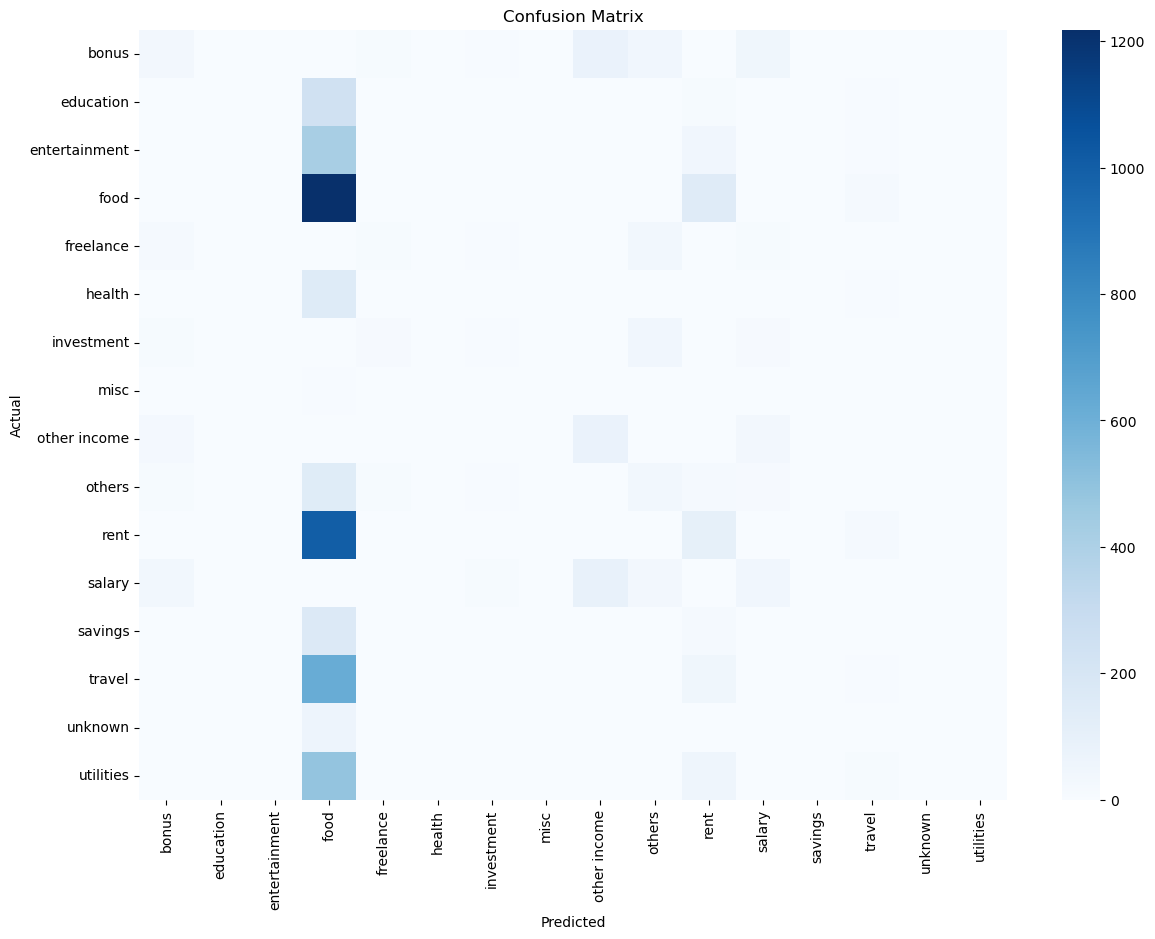

,actual,predicted,notes
20540,travel,food,monthly rent late
4180,entertainment,food,unknown
8055,entertainment,food,fixed deposit
14714,utilities,food,test
19223,rent,food,grocery shopping via app
9374,travel,food,shopping
8340,rent,food,gym membership
13172,rent,food,uber ride
15750,travel,food,unknown
13335,rent,food,gym membership


In [58]:
#Model Evaluation & Error Analysis

#Predictions
y_pred = nb.predict(X_test)

#Basic metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)

plt.figure(figsize=(14,10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=nb.classes_,
            yticklabels=nb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Error analysis: show top mistakes
errors = pd.DataFrame({
    "actual": y_test,
    "predicted": y_pred,
    "notes": X_test["notes"]
})

#Only wrong predictions
errors = errors[errors["actual"] != errors["predicted"]]

#Show first 20 mistakes
errors.head(20)

In [59]:
#Hyperparameter tuning for Naive Bayes + TF-IDF

text_col = "notes"
cat_cols = ["payment_mode", "location", "transaction_type"]
num_cols = ["amount"]

def extract_date_features(df_in):
    df2 = df_in.copy()
    dates = pd.to_datetime(df2["date"], errors="coerce")
    df2["dt_year"] = dates.dt.year.fillna(0).astype(int)
    df2["dt_month"] = dates.dt.month.fillna(0).astype(int)
    df2["dt_day"] = dates.dt.day.fillna(0).astype(int)
    df2["dt_dow"] = dates.dt.dayofweek.fillna(0).astype(int)
    return df2[["dt_year","dt_month","dt_day","dt_dow"]]

date_transformer = Pipeline([
    ("extract", FunctionTransformer(extract_date_features, validate=False)),
    ("impute", SimpleImputer(strategy="constant", fill_value=0)),
    ("scale", MinMaxScaler())
])

text_transformer = TfidfVectorizer(stop_words="english")

cat_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols),
        ("date", date_transformer, ["date"])
    ],
    remainder="drop"
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", MultinomialNB())
])

#Hyperparameters to search
params = {
    "pre__text__max_features": [5000, 10000, 20000],
    "pre__text__ngram_range": [(1,1), (1,2)],
    "clf__alpha": [0.1, 0.5, 1.0]
}

grid = GridSearchCV(
    pipeline,
    params,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

#Final model
best_model = grid.best_estimator_

#Evaluate on test set
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

#Save final model
joblib.dump(best_model, "output/nb_tuned_pipeline.joblib")
print("Saved: output/nb_tuned_pipeline.joblib")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'clf__alpha': 1.0, 'pre__text__max_features': 5000, 'pre__text__ngram_range': (1, 1)}
Best CV Accuracy: 0.2675129111950188
Test Accuracy: 0.26369235891459963
               precision    recall  f1-score   support

        bonus       0.25      0.17      0.20       234
    education       0.00      0.00      0.00       266
entertainment       0.00      0.00      0.00       472
         food       0.27      0.91      0.42      1391
    freelance       0.21      0.10      0.13        93
       health       0.00      0.00      0.00       164
   investment       0.15      0.07      0.09        91
         misc       0.00      0.00      0.00         9
 other income       0.32      0.65      0.43       149
       others       0.20      0.17      0.18       254
         rent       0.24      0.08      0.12      1131
       salary       0.23      0.14      0.17       232
      savings       0.00      0.00      0.00       

In [60]:
#Train Logistic Regression baseline (strong model)

text_col = "notes"
cat_cols = ["payment_mode", "location", "transaction_type"]
num_cols = ["amount"]

#date feature extractor
def extract_date_features(df_in):
    df2 = df_in.copy()
    dates = pd.to_datetime(df2["date"], errors="coerce")
    df2["dt_year"] = dates.dt.year.fillna(0).astype(int)
    df2["dt_month"] = dates.dt.month.fillna(0).astype(int)
    df2["dt_day"] = dates.dt.day.fillna(0).astype(int)
    df2["dt_dow"] = dates.dt.dayofweek.fillna(0).astype(int)
    return df2[["dt_year","dt_month","dt_day","dt_dow"]]

date_transformer = Pipeline([
    ("extract", FunctionTransformer(extract_date_features, validate=False)),
    ("impute", SimpleImputer(strategy="constant", fill_value=0)),
    ("scale", MinMaxScaler())
])

#text + categorical + numeric transformers
text_transformer = TfidfVectorizer(max_features=20000, stop_words="english")

cat_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

#full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols),
        ("date", date_transformer, ["date"])
    ],
    remainder="drop"
)

#Logistic Regression model
lr = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight="balanced",
        solver="lbfgs",
        multi_class="auto"
    ))
])

#Train
lr.fit(X_train, y_train)

#Evaluate
y_pred_lr = lr.predict(X_test)
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, zero_division=0))

#Save
joblib.dump(lr, "output/lr_pipeline.joblib")
print("Saved: output/lr_pipeline.joblib")

LR Accuracy: 0.10071583152988181
               precision    recall  f1-score   support

        bonus       0.35      0.10      0.16       234
    education       0.08      0.17      0.11       266
entertainment       0.13      0.05      0.07       472
         food       0.31      0.08      0.13      1391
    freelance       0.19      0.41      0.26        93
       health       0.04      0.22      0.07       164
   investment       0.19      0.44      0.27        91
         misc       0.00      0.22      0.00         9
 other income       0.31      0.72      0.43       149
       others       0.08      0.05      0.06       254
         rent       0.19      0.05      0.08      1131
       salary       0.27      0.09      0.14       232
      savings       0.05      0.27      0.09       195
       travel       0.11      0.01      0.03       676
      unknown       0.01      0.07      0.02        86
    utilities       0.11      0.04      0.06       564

     accuracy                 

In [61]:
#Logistic Regression WITHOUT notes (structured features only)

#Columns to use
cat_cols = ["payment_mode", "location", "transaction_type"]
num_cols = ["amount"]

#date feature extractor
def extract_date_features(df_in):
    df2 = df_in.copy()
    dates = pd.to_datetime(df2["date"], errors="coerce")
    df2["dt_year"] = dates.dt.year.fillna(0).astype(int)
    df2["dt_month"] = dates.dt.month.fillna(0).astype(int)
    df2["dt_day"] = dates.dt.day.fillna(0).astype(int)
    df2["dt_dow"] = dates.dt.dayofweek.fillna(0).astype(int)
    return df2[["dt_year","dt_month","dt_day","dt_dow"]]

date_transformer = Pipeline([
    ("extract", FunctionTransformer(extract_date_features, validate=False)),
    ("impute", SimpleImputer(strategy="constant", fill_value=0)),
    ("scale", MinMaxScaler())
])

#categorical + numeric transformers
cat_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

#full preprocessor (No text transformer)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols),
        ("date", date_transformer, ["date"]),
    ],
    remainder="drop"
)

#Logistic Regression
lr_structured = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

#Train
lr_structured.fit(X_train, y_train)

#Evaluate
y_pred_lr_struct = lr_structured.predict(X_test)
print("Structured LR Accuracy:", accuracy_score(y_test, y_pred_lr_struct))
print(classification_report(y_test, y_pred_lr_struct, zero_division=0))

#Save
joblib.dump(lr_structured, "output/lr_structured_pipeline.joblib")
print("Saved: output/lr_structured_pipeline.joblib")

Structured LR Accuracy: 0.08123855501914433
               precision    recall  f1-score   support

        bonus       0.00      0.00      0.00       234
    education       0.05      0.08      0.06       266
entertainment       0.12      0.04      0.06       472
         food       0.29      0.01      0.02      1391
    freelance       0.20      0.52      0.29        93
       health       0.04      0.27      0.07       164
   investment       0.20      0.37      0.26        91
         misc       0.00      0.67      0.01         9
 other income       0.31      0.97      0.47       149
       others       0.00      0.00      0.00       254
         rent       0.21      0.07      0.11      1131
       salary       0.24      0.02      0.03       232
      savings       0.05      0.24      0.08       195
       travel       0.10      0.01      0.03       676
      unknown       0.01      0.01      0.01        86
    utilities       0.13      0.02      0.04       564

     accuracy      

In [62]:
#Train Random Forest Classifier (handles noisy data better)

#Feature groups
text_col = "notes"
cat_cols = ["payment_mode", "location", "transaction_type"]
num_cols = ["amount"]

#Date features
def extract_date_features(df_in):
    df2 = df_in.copy()
    dates = pd.to_datetime(df2["date"], errors="coerce")
    df2["dt_year"] = dates.dt.year.fillna(0).astype(int)
    df2["dt_month"] = dates.dt.month.fillna(0).astype(int)
    df2["dt_day"] = dates.dt.day.fillna(0).astype(int)
    df2["dt_dow"] = dates.dt.dayofweek.fillna(0).astype(int)
    return df2[["dt_year","dt_month","dt_day","dt_dow"]]

date_transformer = Pipeline([
    ("extract", FunctionTransformer(extract_date_features, validate=False)),
    ("impute", SimpleImputer(strategy="constant", fill_value=0)),
    ("scale", MinMaxScaler())
])

#Text transformer
text_transformer = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, stop_words="english"))
])

#Categorical + Numeric transformers
cat_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

#Full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols),
        ("date", date_transformer, ["date"]),
    ],
    remainder="drop"
)

#Random Forest model
rf = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

#Train
rf.fit(X_train, y_train)

#Evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))

#Save
joblib.dump(rf, "output/rf_pipeline.joblib")
print("Saved: output/rf_pipeline.joblib")

Random Forest Accuracy: 0.20559347428000666
               precision    recall  f1-score   support

        bonus       0.25      0.24      0.24       234
    education       0.07      0.06      0.06       266
entertainment       0.10      0.08      0.09       472
         food       0.26      0.32      0.29      1391
    freelance       0.22      0.24      0.23        93
       health       0.01      0.01      0.01       164
   investment       0.18      0.16      0.17        91
         misc       0.00      0.00      0.00         9
 other income       0.35      0.54      0.42       149
       others       0.12      0.13      0.12       254
         rent       0.32      0.30      0.31      1131
       salary       0.26      0.21      0.23       232
      savings       0.03      0.05      0.04       195
       travel       0.15      0.12      0.14       676
      unknown       0.01      0.01      0.01        86
    utilities       0.11      0.09      0.10       564

     accuracy      

In [63]:
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor

def run_notebook(path):
    with open(path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    ep = ExecutePreprocessor(timeout=None, kernel_name="python3")
    ep.preprocess(nb)

    print(f"{path} ran successfully")

run_notebook("predict_code.ipynb")
run_notebook("app_code.ipynb")

predict_code.ipynb ran successfully
app_code.ipynb ran successfully
